# ***Libraries & Tools***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform, chi2_contingency


import time
import json
import math
import re

# NLP tools
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

# Scikit-Learn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report, RocCurveDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline
from sklearn import tree

# Imbalanced learn library
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTEN, SMOTENC, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

# Boosting ensemble methods
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from itertools import product
from IPython.display import Image
import pydotplus
import graphviz
import shap

SEED = 42

/home/georgematlis/AUTH/DWS/ADVANCED_TOPICS_IN_MACHINE_LEARNING/CDC-BRFSS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
# Download punkt package for wordcloud
nltk.download('punkt', download_dir='/home/georgematlis/AUTH/DWS/ADVANCED_TOPICS_IN_MACHINE_LEARNING/CDC-BRFSS/Downloaded_Files')

[nltk_data] Downloading package punkt to /home/georgematlis/AUTH/DWS/A
[nltk_data]     DVANCED_TOPICS_IN_MACHINE_LEARNING/CDC-
[nltk_data]     BRFSS/Downloaded_Files...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Specify the path to the tokenizers
nltk.data.path.append("/home/georgematlis/AUTH/DWS/ADVANCED_TOPICS_IN_MACHINE_LEARNING/CDC-BRFSS/Downloaded_Files")

# ***Data Overview and Exploration***

## Data Overview

In [3]:
data = pd.read_csv('MMSA_2021.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227792 entries, 0 to 227791
Columns: 152 entries, DISPCODE to MMSANAME
dtypes: float64(151), object(1)
memory usage: 264.2+ MB


In [4]:
data.head()

,DISPCODE,STATERE1,CELPHON1,LADULT1,COLGSEX,LANDSEX,RESPSLCT,SAFETIME,CADULT1,CELLSEX,...,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_MMSA,_MMSAWT,SEQNO,MMSANAME
0,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,90.030265,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
1,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,29.643176,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
2,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,37.000680,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
3,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,49.702755,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
4,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,15.396983,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"


In [ ]:
# Some columns have many null values
isna_data = data.isna().sum()
for column, count in isna_data.items():
    print(f"{column}: {count}")

In [ ]:
# If we were to drop all null values, the data would have no records left
data.dropna().shape

## Hand-pick Variables
Select some interesting columns from the dataset.

#### Columns

In [4]:
columns = [
    # === List with all meaningful columns ===
    [
        # Sec 1 Health Status
        '_RFHLTH',

        # Sec 2 Healthy Days
        '_PHYS14D',
        '_MENT14D',

        # Sec 3 Health Care Access
        '_HLTHPLN',
        '_HCVU652',

        # Sec 4 Exercise
        '_TOTINDA',

        # Sec 5 Hypertension Awareness
        '_RFHYPE6',

        # Sec 6 Cholesterol Awareness
        '_CHOLCH3',
        '_RFCHOL3',

        # Sec 7 Chronic Health Conditions
        '_MICHD',

        # Sec 8 Arthritis
        '_DRDXAR3',
        '_LMTACT3',
        '_LMTWRK3',

        # Sec 11 Tobacco Use
        '_SMOKER3',
        '_RFSMOK3',
        '_CURECI1',

        # Sec 12 Alcohol Consumption
        'DRNKANY5',
        'ALCDAY5',
        '_RFBING5',
        '_DRNKWK1',
        '_RFDRHV7',

        # Sec 14 HIV/AIDS
        '_AIDTST4',

        # Sec 15 Fruits & Vegetables
        'FTJUDA2_',
        'FRUTDA2_',
        'GRENDA1_',
        'FRNCHDA_',
        'POTADA1_',
        'VEGEDA2_',
        '_FRUTSU1',
        '_VEGESU1',
        '_FRTLT1A',
        '_VEGLT1A',
        
        # Sec 9 Demographics
        '_INCOMG1',
        '_EDUCAG',
        'CHILDREN',
        '_RFBMI5',
        '_BMI5CAT',
        '_BMI5',
        'WTKG3',
        'HEIGHT3',
        '_AGE_G',
        '_AGE80',
        '_AGE65YR',
        '_AGEG5YR',
        '_SEX',
        '_RACEPRV',
        '_RACEGR3',
        '_RACEG21',
        '_RACE',
        '_HISPANC',
        '_MRACE1',
        '_PRACE1'
    ],

    # === 1st subset of all the meaningful columns === 
    [
        # Sec 1 Health Status
        '_RFHLTH',

        # Sec 2 Healthy Days
        '_PHYS14D',
        '_MENT14D',

        # Sec 3 Health Care Access
        '_HLTHPLN',
        '_HCVU652',

        # Sec 4 Exercise
        '_TOTINDA',

        # Sec 5 Hypertension Awareness
        '_RFHYPE6',

        # Sec 6 Cholesterol Awareness
        '_CHOLCH3',
        '_RFCHOL3',

        # Sec 7 Chronic Health Conditions
        '_MICHD',

        # Sec 8 Arthritis

        # Sec 11 Tobacco Use
        '_SMOKER3',

        # Sec 12 Alcohol Consumption
        '_RFBING5',
        '_RFDRHV7',

        # Sec 14 HIV/AIDS
        '_AIDTST4',

        # Sec 15 Fruits & Vegetables
        '_FRUTSU1',
        '_VEGESU1',
        
        # Sec 9 Demographics
        '_INCOMG1',
        '_EDUCAG',
        '_RFBMI5',
        '_BMI5CAT',
        '_AGE_G',
        '_SEX',
        '_RACE'
    ],


    # === 2nd subset of all the meaningul columns ===
    [
        # Sec 1 Health Status
        '_RFHLTH',

        # Sec 2 Healthy Days
        '_PHYS14D',
        '_MENT14D',

        # Sec 3 Health Care Access
        '_HLTHPLN',
        '_HCVU652',

        # Sec 4 Exercise
        '_TOTINDA',

        # Sec 5 Hypertension Awareness
        '_RFHYPE6',

        # Sec 6 Cholesterol Awareness
        '_CHOLCH3',
        '_RFCHOL3',

        # Sec 7 Chronic Health Conditions
        '_MICHD',

        # Sec 8 Arthritis
        

        # Sec 11 Tobacco Use
        '_SMOKER3',

        # Sec 12 Alcohol Consumption
        '_RFBING5',
        '_RFDRHV7',

        # Sec 14 HIV/AIDS
        '_AIDTST4',

        # Sec 15 Fruits & Vegetables
        '_FRTLT1A',
        '_VEGLT1A',
        
        # Sec 9 Demographics
        '_INCOMG1',
        '_EDUCAG',
        '_RFBMI5',
        '_BMI5CAT',
        '_AGE_G',
        '_SEX',
        '_RACE'
    ]
]

#### Categorical and Continuous Columns
We can use the one hot encoder to properly encode the values of each categorical variable that exhibits no apparent order.

In [5]:
"""

1: For categorical
2: For continuous

"""

cat_con_variables = {
    # Sec 1 Health Status
    '_RFHLTH': 1,

    # Sec 2 Healthy Days
    '_PHYS14D': 1,
    '_MENT14D': 1,

    # Sec 3 Health Care Access
    '_HLTHPLN': 1,
    '_HCVU652': 1,

    # Sec 4 Exercise
    '_TOTINDA': 1,

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': 1,

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': 1,
    '_RFCHOL3': 1,

    # Sec 7 Chronic Health Conditions
    '_MICHD': 1,

    # Sec 8 Arthritis
    '_DRDXAR3': 1,
    '_LMTACT3': 1,
    '_LMTWRK3': 1,

    # Sec 11 Tobacco Use
    '_SMOKER3': 1,
    '_RFSMOK3': 1,
    '_CURECI1': 1,

    # Sec 12 Alcohol Consumption
    'DRNKANY5': 1,
    'ALCDAY5': 2,
    '_RFBING5': 1,
    '_DRNKWK1': 2,
    '_RFDRHV7': 1,

    # Sec 14 HIV/AIDS
    '_AIDTST4': 1,

    # Sec 15 Fruits & Vegetables
    'FTJUDA2_': 2,
    'FRUTDA2_': 2,
    'GRENDA1_': 2,
    'FRNCHDA_': 2,
    'POTADA1_': 2,
    'VEGEDA2_': 2,
    '_FRUTSU1': 2,
    '_VEGESU1': 2,
    '_FRTLT1A': 1,
    '_VEGLT1A': 1,
    
    # Sec 9 Demographics
    '_INCOMG1': 1,
    '_EDUCAG': 1,
    'CHILDREN': 1,
    '_RFBMI5': 1,
    '_BMI5CAT': 1,
    '_BMI5': 2,
    'WTKG3': 2,
    'HEIGHT3': 2,
    
    # === The age variables can remain the same because their values represent a natural ordering ===
    '_AGE_G': 1,
    '_AGE80': 1,
    '_AGE65YR': 1,
    '_AGEG5YR': 1,
    
    '_SEX': 1,
    '_RACEPRV': 1,
    '_RACEGR3': 1,
    '_RACEG21': 1,
    '_RACE': 1,
    '_HISPANC': 1,
    '_MRACE1': 1,
    '_PRACE1': 1
}

#### Column Values that are Irrelevant
Some columns/variables have values, such as "Dont Know/Not Sure", that are irrelevant to the analysis. These values are included in data mining methods but can be ignored in NLP mehtods. NLP methods handle text sequences of varying forms.

In [6]:
irrel_col_values = {
    # Sec 1 Health Status
    '_RFHLTH': 9,

    # Sec 2 Healthy Days
    '_PHYS14D': 9,
    '_MENT14D': 9,

    # Sec 3 Health Care Access
    '_HLTHPLN': 9,
    '_HCVU652': 9,

    # Sec 4 Exercise
    '_TOTINDA': 9,

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': 9,

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': 9,
    '_RFCHOL3': 9,

    # Sec 7 Chronic Health Conditions

    # Sec 8 Arthritis
    '_LMTACT3': 9,
    '_LMTWRK3': 9,

    # Sec 11 Tobacco Use
    '_SMOKER3': 9,
    '_RFSMOK3': 9,
    '_CURECI1': 9,

    # Sec 12 Alcohol Consumption
    'DRNKANY5': 9,
    'ALCDAY5': 900,
    '_RFBING5': 9,
    '_DRNKWK1': 99900,
    '_RFDRHV7': 9,

    # Sec 14 HIV/AIDS
    '_AIDTST4': 9,

    # Sec 15 Fruits & Vegetables
    '_FRTLT1A': 9,
    '_VEGLT1A': 9,
    
    # Sec 9 Demographics
    '_INCOMG1': 9,
    '_EDUCAG': 9,
    'CHILDREN': 9,
    '_RFBMI5': 9,
    '_AGE65YR': 3,
    '_AGEG5YR': 14,
    '_RACEGR3': 9,
    '_RACEG21': 9,
    '_RACE': 9,
    '_HISPANC': 9,
    '_MRACE1': [77,99],
    '_PRACE1': [77, 99]
}

In [7]:
for column, values in irrel_col_values.items():
    if isinstance(values, int):  
        num_rows = len(data[data[column] == values])
        print(f"Number of rows with value {values} in column '{column}': {num_rows}")
    elif isinstance(values, list):  
        num_rows = len(data[data[column].isin(values)])
        print(f"Number of rows with values in {values} in column '{column}': {num_rows}")

# Calculating the size of the dataset after removing rows with specified values
filtered_data = data.copy() 
for column, values in irrel_col_values.items():
    if isinstance(values, int):  
        filtered_data = filtered_data[filtered_data[column] != values]
    elif isinstance(values, list):  
        filtered_data = filtered_data[~filtered_data[column].isin(values)]

# Calculate the size of the filtered dataset
filtered_size = filtered_data.shape[0]
print(f"Size of the dataset after removing rows with specified values: {filtered_size}")

Number of rows with value 9 in column '_RFHLTH': 601
Number of rows with value 9 in column '_PHYS14D': 4691
Number of rows with value 9 in column '_MENT14D': 4011
Number of rows with value 9 in column '_HLTHPLN': 9341
Number of rows with value 9 in column '_HCVU652': 83992
Number of rows with value 9 in column '_TOTINDA': 454
Number of rows with value 9 in column '_RFHYPE6': 1031
Number of rows with value 9 in column '_CHOLCH3': 15155
Number of rows with value 9 in column '_RFCHOL3': 1639
Number of rows with value 9 in column '_LMTACT3': 712
Number of rows with value 9 in column '_LMTWRK3': 1664
Number of rows with value 9 in column '_SMOKER3': 14005
Number of rows with value 9 in column '_RFSMOK3': 14005
Number of rows with value 9 in column '_CURECI1': 13478
Number of rows with value 9 in column 'DRNKANY5': 15146
Number of rows with value 900 in column 'ALCDAY5': 0
Number of rows with value 9 in column '_RFBING5': 19641
Number of rows with value 99900 in column '_DRNKWK1': 19412
Numb

Some columns described in the 2021 SMART City and Country CodeBook are derived from other columns in the dataset.

- DROCDY3_ Calculated variable for drink-occasions-per-day. DROCDY3_ is derived from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month.

- _CHLDCNT Calculated variable for number of children in household. _CHLDCNT is derived from CHILDREN.

- HTM4 Calculated variable for reported height in meters. HTM4 is derived from the variable HTIN4 by multiplying HTIN4 by 2.54 cm per in and dividing by 100 cm per meter. HTM4 is derived from HEIGHT2 metric values by dividing by 100.

- HTIN4 Calculated variable for reported height in inches. HTIN4 is derived from HEIGHT3. HTIN4 is calculated by adding the foot portion of HEIGHT3 multiplied by 12, to the inch portion. 

## Candidate Dataframe Creation

In [ ]:
# Check if the columns selected earlier exist in the dataset
for col in columns[0]:
    if col in data.columns:
        print(col)
    else:
        print(f'{col} does not exist')

In [ ]:
# How many null values each selected column has
isna_data = data[columns[0]].isna().sum()
for column, count in isna_data.items():
    print(f"{column}: {count}")

In [7]:
# Create dataframes based on the selected columns
# Question: Should we drop the rows with null values?
dataframes = [
    data[columns[0]].dropna().copy(),
    data[columns[1]].dropna().copy(),
    data[columns[2]].dropna().copy(),
]

In [ ]:
dataframes[2].info()

In [8]:
# Store all categorical only columns in a list
object_cols = []
for col, cat_con_var in cat_con_variables.items():
    if cat_con_var == 1:
        object_cols.append(col)

print(f'Categorical Columns: \n{object_cols}')

Categorical Columns: 
['_RFHLTH', '_PHYS14D', '_MENT14D', '_HLTHPLN', '_HCVU652', '_TOTINDA', '_RFHYPE6', '_CHOLCH3', '_RFCHOL3', '_MICHD', '_DRDXAR3', '_LMTACT3', '_LMTWRK3', '_SMOKER3', '_RFSMOK3', '_CURECI1', 'DRNKANY5', '_RFBING5', '_RFDRHV7', '_AIDTST4', '_FRTLT1A', '_VEGLT1A', '_INCOMG1', '_EDUCAG', 'CHILDREN', '_RFBMI5', '_BMI5CAT', '_AGE_G', '_AGE80', '_AGE65YR', '_AGEG5YR', '_SEX', '_RACEPRV', '_RACEGR3', '_RACEG21', '_RACE', '_HISPANC', '_MRACE1', '_PRACE1']


In [8]:
for dataframe in dataframes:
    dataframe['_MICHD'] = dataframe['_MICHD'].replace({1.0: 0, 2.0: 1})
    dataframe['_MICHD'] = dataframe['_MICHD'].astype('int64')

    # Convert categorical columns to integers. Categorical columns have float numerical values representing their categories, e.g 1.0, 2.0, 3.0
    for column, col_type in cat_con_variables.items():
        if col_type == 1 and (column in dataframe.columns):  # Check if the column is categorical
            dataframe[column] = dataframe[column].astype('int64')

In [10]:
# Use this if you want to utilize the one hot encoder
# The one hot encoder will create sub-variables for each distinct value of a variable
selected_cols = [col for col in set(object_cols) & set(dataframes[2].columns) if col != '_MICHD']

dataframes[2] = pd.get_dummies(dataframes[2], columns=selected_cols)

In [11]:
dataframes[2]['_MICHD'].value_counts()

_MICHD
1    153711
0     13872
Name: count, dtype: int64

In [12]:
dataframes[2].shape

(167583, 85)

In [11]:
# Print the total number of duplicates for one of the categories of variable "_MICHD"
dataframes[2][dataframes[2]['_MICHD'] == 1].duplicated().sum()

32930

In [ ]:
dataframes[2].info()

### Frequency of Variable Categories

In [ ]:
# Split variables into groups of five
variable_groups = [dataframes[2].columns[i:i+5] for i in range(0, len(dataframes[2].columns), 5)]

# Plot each group of variables
for group in variable_groups:
    plt.figure(figsize=(12, 6))
    for idx, variable in enumerate(group):
        plt.subplot(math.ceil(len(group)/2), 2, idx+1)
        sns.countplot(data=dataframes[2], x=variable, hue=variable, palette='Set3', legend=False)
        plt.title(f'Frequency of Categories in {variable}')
        plt.xlabel('Categories')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Chi-Squared Test Analysis

In [24]:
# Create an empty DataFrame to store the results
chi_squared_results = []


for col in [col for col in columns[2] if col != '_MICHD']:
    contingency_table = pd.crosstab(dataframes[2][col], dataframes[2]['_MICHD'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    

    # Append the results to the DataFrame
    chi_squared_results.append({'Independent Variable': col,
                              'Chi-square Value': chi2,
                              'P-value': p_value})
    
    """
    print(f"Chi-square test for independence between {col} and {'_MICHD'}:")
    print(f"Chi-square value: {chi2}")
    print(f"P-value: {p_value}")
    print("")

    # You can perform further analysis based on the p-value and significance level
    # For example:
    if p_value < 0.05:  # Assuming a significance level of 0.05
        print(f"The p-value is less than 0.05, indicating that {col} is likely dependent on {'_MICHD'}.")
    else:
        print(f"The p-value is greater than 0.05, indicating that {col} is likely independent of {'_MICHD'}.")
    print("")
    """
chi_squared_results_df = pd.DataFrame(chi_squared_results)
print(chi_squared_results_df)

   Independent Variable  Chi-square Value        P-value
0               _RFHLTH       7650.663883   0.000000e+00
1              _PHYS14D       4268.662883   0.000000e+00
2              _MENT14D        464.365123  2.515920e-100
3              _HLTHPLN         96.618771   1.045925e-21
4              _HCVU652       5983.420192   0.000000e+00
5              _TOTINDA       1663.766148   0.000000e+00
6              _RFHYPE6       6697.390558   0.000000e+00
7              _CHOLCH3        262.036886   6.173480e-59
8              _RFCHOL3       4740.451737   0.000000e+00
9              _SMOKER3       2021.200796   0.000000e+00
10             _RFBING5        651.940519  2.709661e-142
11             _RFDRHV7        120.394056   7.190565e-27
12             _AIDTST4        200.666633   2.665596e-44
13             _FRTLT1A         35.432240   2.022957e-08
14             _VEGLT1A        146.811814   1.318924e-32
15             _INCOMG1       2093.487975   0.000000e+00
16              _EDUCAG       1

### Cramer's V Method for Correlation

In [29]:
# Encode categorical variables
encoded_df = pd.get_dummies(dataframes[2], drop_first=True)  # One-hot encoding

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate Cramér's V for each pair of variables
cramers_v_values = {}
for col1 in encoded_df.columns:
    for col2 in encoded_df.columns:
        cramers_v_values[(col1, col2)] = cramers_v(encoded_df[col1], encoded_df[col2])


# Create a correlation table
correlation_table = pd.DataFrame(index=encoded_df.columns, columns=encoded_df.columns)
for col1 in encoded_df.columns:
    for col2 in encoded_df.columns:
        correlation_table.loc[col1, col2] = cramers_v_values[(col1, col2)]

# Create an empty dictionary to store associations
association_dict = {}

# Iterate over each variable in the correlation table
for var1 in correlation_table.columns:
    # Create an inner dictionary to store associations with other variables
    inner_dict = {}
    
    # Iterate over other variables
    for var2 in correlation_table.columns:
        # Skip the current variable
        if var1 == var2:
            continue
        
        # Get the correlation value between var1 and var2 from the original correlation table
        association_value = correlation_table.loc[var1, var2]
        
        # Store the association value in the inner dictionary
        inner_dict[var2] = association_value
    
    # Sort the inner dictionary based on correlation values
    sorted_inner_dict = {k: v for k, v in sorted(inner_dict.items(), key=lambda item: item[1], reverse=True)}

    # Store the inner dictionary in the outer dictionary
    association_dict[var1] = sorted_inner_dict

In [30]:
for var1, inner_dict in association_dict.items():
    print(f"{var1}:")
    for var2, association_value in inner_dict.items():
        print(f"  {var2}: {association_value}")

_RFHLTH:
  _PHYS14D: 0.3614064284613051
  _MICHD: 0.21363829499934134
  _INCOMG1: 0.1935867208013684
  _TOTINDA: 0.18029964894301873
  _MENT14D: 0.17143570592315746
  _EDUCAG: 0.15204789025587417
  _RFHYPE6: 0.13517998796401912
  _SMOKER3: 0.10057197701484735
  _BMI5CAT: 0.0977096647006075
  _RFCHOL3: 0.09291320987420845
  _AGE_G: 0.07929579365029235
  _RFBMI5: 0.0684755915778215
  _VEGLT1A: 0.06726165464569893
  _RACE: 0.06659320210777403
  _HCVU652: 0.06226586351954926
  _FRTLT1A: 0.041714917712912046
  _RFBING5: 0.04004045008712682
  _AIDTST4: 0.03235917549083652
  _HLTHPLN: 0.029593844701554028
  _CHOLCH3: 0.021763368271458052
  _RFDRHV7: 0.020303714527265388
  _SEX: 0.018633063685266255
_PHYS14D:
  _RFHLTH: 0.36140642846130516
  _MENT14D: 0.2259787574960069
  _TOTINDA: 0.16818639229380167
  _MICHD: 0.15954367057453467
  _INCOMG1: 0.13090327181619776
  _RFHYPE6: 0.09931600485496782
  _EDUCAG: 0.0831936525736148
  _RFCHOL3: 0.07530743213427221
  _SMOKER3: 0.06985201978885339
  _VEGL

### Dataset Sample Creation
Create a sample for one of the dataframes for later feature extraction and classification. Another method we can use to take a sample is to split the original dataframe and apply a combination of oversampling and undersampling to the training set.

First way to create a sample: 
- Take all the samples from the minority class
- Define a percentage of samples that you want to take and subtract the number of minority class samples; that will be the number of majority class samples

In [77]:
# Take all minority samples. Including duplicates
minority_samples = dataframes[2][dataframes[2]['_MICHD'] == 0] 
num_minority_samples = len(minority_samples)

"""
Lets say that we want to take p% of the original dataframe as a sample. The first step we have to take is subtract the number of minority samples assuming we have already included them in our sample.
The second step is to add the necessary number of majority samples in our sample until we reach the upper limit which is p% of samples. We can add some of the unique samples from the majority class 
to the sample or we can randomly pick some of them. Below, we add unique samples to the sample.
"""
num_majority_samples =  math.floor(dataframes[2].shape[0] * 0.25) - num_minority_samples
majority_unique_samples = dataframes[2][dataframes[2]['_MICHD'] == 1].drop_duplicates()
num_unique_majority_samples = len(majority_unique_samples) # Not needed

majority_samples = majority_unique_samples.sample(n=num_majority_samples)

dataframe_sample = pd.concat([minority_samples, majority_samples])

Second way to create a sample:
- Perform stratified sampling using a percentage of samples

In [ ]:
# Specify the fraction of samples you want to retain in the subset (e.g., 0.5 for 50%)
subset_fraction = 0.20

# Perform stratified sampling to create a smaller dataframe
dataframe_sample = dataframes[2].groupby('_MICHD', group_keys = False).apply(lambda x: x.sample(frac = subset_fraction))

Third way to create a sample:
- Undersample the majority class so we can keep all instances of the minority class, thereby reducing the overall size of the dataset. The downside of this approach is we lose valuable instances of the majority class.

In [9]:
# Define the undersampler
undersampler = RandomUnderSampler(random_state=SEED)

# Separate features (X) and target variable (y)
x = dataframes[2].drop(columns=['_MICHD'])
y = dataframes[2]['_MICHD']

# Perform undersampling
x_resampled, y_resampled = undersampler.fit_resample(x, y)

# Construct the balanced DataFrame
dataframe_sample = pd.concat([x_resampled, y_resampled], axis=1)

In [10]:
dataframe_sample.shape

(27744, 23)

In [14]:
dataframe_sample['_MICHD'].value_counts()

_MICHD
0    13872
1    13872
Name: count, dtype: int64

In [ ]:
dataframe_sample.info()

## Feature Importance with Random Forests
We can use the GridSearchCV, or the RandomizedSearchCV method with the Random Forest algorithm to evaluate the importance of each variable in assessing the risk of MI or CHD.

In [16]:
target_column = "_MICHD"

#y = dataframes[2][target_column]
#x = dataframes[2].drop(columns=[target_column])

y = dataframe_sample[target_column]
x = dataframe_sample.drop(columns = [target_column])

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED, stratify=y)

In [24]:
# Define the cost matrix
cost_matrix = [[0, 0.25],  # Cost of false positive 
               [1, 0]]  # Cost of false negative

In [22]:
# Define a custom scoring function using the cost matrix
def custom_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cost = np.sum(cm * cost_matrix)
    return -cost  # Minimize cost, so negative of cost is returned

In [26]:
# Make the custom scoring function into a scorer object
custom_scorer = make_scorer(custom_score, greater_is_better = False)

### Random Search

In [135]:
# Define the parameter distributions to sample from
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(10, 41)),
    'min_samples_split': randint(2, 21),
    'class_weight': [{0: 1, 1: 0.25}]
}

# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=SEED)

# Initialize RandomizedSearchCV with custom scoring
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                                   scoring=make_scorer(f1_score, average='weighted'), n_jobs=4, random_state=SEED)


### Grid Search

In [65]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'class_weight': [{0: 1, 1: 0.25}]
}

# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=SEED)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, n_jobs=4, scoring=make_scorer(f1_score, average='weighted'))


### Initialize search, output the best parameters, and print feature importance

In [136]:
random_search.fit(x_train, y_train)
#grid_search.fit(x, y)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=4,
                   param_distributions={'class_weight': [{0: 1, 1: 0.25}],
                                        'max_depth': [None, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27, 28, 29, 30, 31, 32,
                                                      33, 34, 35, 36, 37, 38, ...],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7948058ab5b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x794805828be0>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [137]:
# Get the best parameters from the random search
best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Get the best estimator (Random Forest classifier with the best parameters)
best_rf_classifier = random_search.best_estimator_

# Train the best classifier on the entire dataset
best_rf_classifier.fit(x, y)

# Extract feature importance
feature_importances = best_rf_classifier.feature_importances_

Best Parameters: {'class_weight': {0: 1, 1: 0.25}, 'max_depth': 32, 'min_samples_split': 5, 'n_estimators': 153}


Print the importance of each feature if original unaltered variables are used.

In [ ]:
# Sort the features and their importance scores by importance in descending order
sorted_features = sorted(zip(x.columns, feature_importances), key=lambda x: x[1], reverse=True)

# Print all features and their importance scores in descending order
print("\nFeature Importance (Descending Order):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Print the importance of each feature if one hot encoder is used in descending order.

In [139]:
feature_importance_sum = {}

for feature, importance in zip(x.columns, feature_importances):
    feature_name = re.sub(r'(.*?)_\d$', r'\1', feature)

    if feature_name in feature_importance_sum:
        feature_importance_sum[feature_name] += importance
    else:
        feature_importance_sum[feature_name] = importance

sorted_feature_importance_sum = sorted(feature_importance_sum.items(), key=lambda x: x[1], reverse=True)

for feature, importance_sum in sorted_feature_importance_sum:
    print(f"{feature}: {importance_sum}")

_AGE_G: 0.10378490525284366
_INCOMG1: 0.09896199952245247
_HCVU652: 0.07764165379308188
_RFHYPE6: 0.07763948023634709
_EDUCAG: 0.0578318636042885
_RFHLTH: 0.05549590228974927
_RFCHOL3: 0.05404574003870293
_PHYS14D: 0.051028269222555
_RACE: 0.049967238577657634
_SMOKER3: 0.04949376816673063
_MENT14D: 0.04317670659519978
_BMI5CAT: 0.04116992926502239
_AIDTST4: 0.038188030270938686
_FRTLT1A: 0.03676601724944525
_VEGLT1A: 0.03543090405782048
_SEX: 0.03182151319394934
_TOTINDA: 0.02727769554681295
_RFBING5: 0.020129593026226612
_RFBMI5: 0.016887414479694468
_RFDRHV7: 0.013723627853188538
_HLTHPLN: 0.012955427012098343
_CHOLCH3: 0.006582320745193958


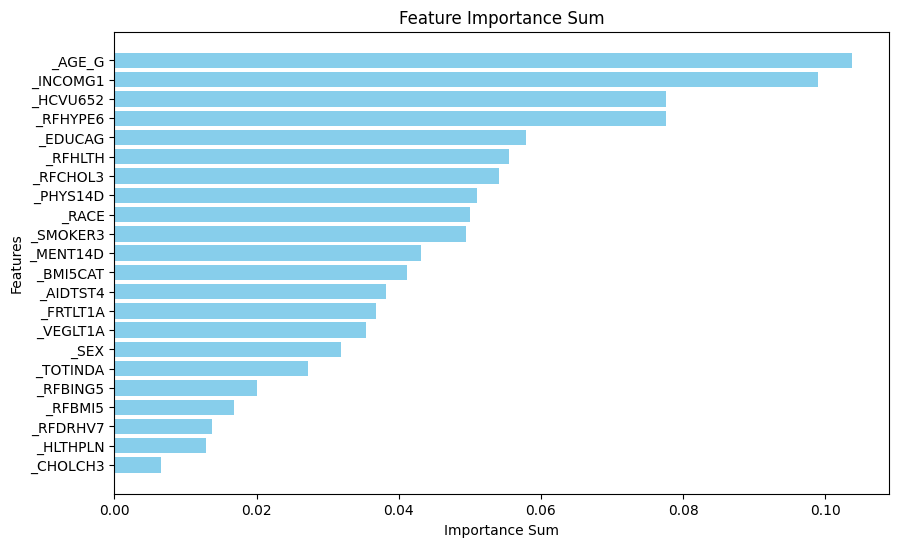

In [140]:
features = [feat for feat, _ in sorted_feature_importance_sum]
importance_sums = [imp_sum for _, imp_sum in sorted_feature_importance_sum]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importance_sums, color='skyblue')
plt.xlabel('Importance Sum')
plt.ylabel('Features')
plt.title('Feature Importance Sum')
plt.gca().invert_yaxis()  # Invert y-axis to display features from top to bottom
plt.show()

Print the top features if original unaltered variables are used.

In [ ]:
num_top_features = 23  # You can adjust this number based on your preference
top_feature_indices = feature_importances.argsort()[-num_top_features:][::-1]
top_features = x.columns[top_feature_indices]

print("Top features:")
for feature in top_features:
    print(feature)

Print the top complete features if one hot encoder is used.

In [ ]:
top_features = [sorted_feature_importance_sum[i][0] for i in range(5)]

complete_features = []

for feature in top_features:
  for column in dataframe_sample.columns:
      if column.startswith(feature):
          suffix = column[len(feature):].lstrip('_')
          if suffix != '':
            complete_part = feature + '_' + suffix
          else:
            complete_part = feature

          complete_features.append(complete_part)

top_features = complete_features
for complete_feat in top_features: print(complete_feat)

# ***Classification with Data Mining Methods***

## Class Frequency of the Target Variable

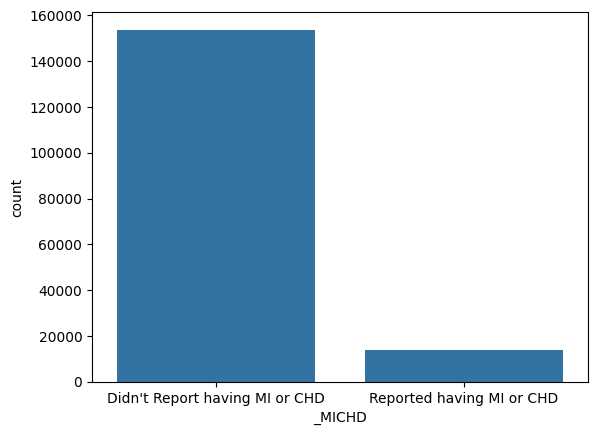

In [13]:
category_labels = ["Didn't Report having MI or CHD", 'Reported having MI or CHD']
sns.countplot(data=dataframes[2], x='_MICHD', order=dataframes[2]['_MICHD'].value_counts().index)
plt.xticks(ticks=range(len(category_labels)), labels=category_labels)
plt.show()

## Generation of Synthetic Data

Here we try different oversampling methods and for each variant we run the model and save the results

In [ ]:
SMOTE_data = dataframes[2].copy()

In [ ]:
SMOTE_data['_MICHD'].value_counts()

In [ ]:
SMOTE_data.drop_duplicates()['_MICHD'].value_counts()

In [ ]:
target_column = "_MICHD"

### First variant: Borderline SMOTE

In [ ]:
# Generate synthetic data for the original imbalanced data
resampled_data = BorderlineSMOTE().fit_resample(SMOTE_data.drop(columns = ['_MICHD']), 
                                        SMOTE_data['_MICHD'])
SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

# This variable specifies the oversampling method we use. 1 is for the first method, 2 is for second and so on. Based on this variable the results are saved to the correct dataframe.
method=1

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [ ]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
BorderlineSMOTE_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
BorderlineSMOTE_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
BorderlineSMOTE_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
BorderlineSMOTE_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])

### Second variant: SMOTE-Tomek

In [ ]:
# Generate synthetic data for the original imbalanced data
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek()
resampled_data = smote_tomek.fit_resample(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'])

SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

# This variable specifies the oversampling method we use. 1 is for the first method, 2 is for second and so on. Based on this variable the results are saved to the correct dataframe.
method=2

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [ ]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
smote_tomek_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
smote_tomek_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
smote_tomek_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
smote_tomek_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])

### Third variant: ADASYN (Adaptive Synthetic Sampling)
ADASYN is an extension of SMOTE that adaptively generates samples according to the local density of minority samples. It focuses more on regions where the class imbalance is more severe.

In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()
resampled_data = adasyn.fit_resample(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'])

SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

# This variable specifies the oversampling method we use. 1 is for the first method, 2 is for second and so on. Based on this variable the results are saved to the correct dataframe.
method=3

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [ ]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
adasyn_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
adasyn_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
adasyn_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
adasyn_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])

<h3 style="text-align: center;"> Fourth variant: SMOTE </h3>

In [ ]:
from imblearn.over_sampling import SMOTE

resampled_data = SMOTE().fit_resample(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'])

SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

# This variable specifies the oversampling method we use. 1 is for the first method, 2 is for second and so on. Based on this variable the results are saved to the correct dataframe.
method=4

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [ ]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
SMOTE_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
SMOTE_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
SMOTE_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])
SMOTE_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'Naive Bayes', 'Random Forests', 'KNN'])

## Classification

In [14]:
target_column = "_MICHD"


# Utilize all the selected dataframe samples 
#y = dataframes[2][target_column]
#x = dataframes[2].drop(columns=[target_column])


# Utilize a dataframe sample 
y = dataframe_sample[target_column]
x = dataframe_sample.drop(columns = [target_column])

In [15]:
# Use this spliting only when undersampling of the majority class has occured and there is no class imbalance
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=SEED)

In [16]:
# Define the cost matrix
cost_matrix = [ 
    [0, 1],  
    [1, 0]
] 

In [17]:
tabular_based_classifiers = {}

### ***XGBoost***

#### XGBoost for undersampling

In [20]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.5),
}

xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=SEED)

random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist, n_iter=50, random_state=SEED,n_jobs=4)

In [21]:
random_search.fit(x_train, y_train)

best_params = random_search.best_params_
print("Best parameters found:", best_params)

Best parameters found: {'learning_rate': 0.017818203370596968, 'max_depth': 3, 'n_estimators': 443}


In [22]:
#best_xgb_model = random_search.best_estimator_

xgboost_clf = XGBClassifier(n_estimators=443, max_depth=3, learning_rate=0.018, objective='binary:logistic', random_state=SEED)
xgboost_clf = CalibratedClassifierCV(xgboost_clf, method='isotonic')
xgboost_clf.fit(x_train, y_train)

tabular_based_classifiers['XGBoost'] = xgboost_clf

y_pred = xgboost_clf.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print("Total Cost:", total_cost)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      3504
           1       0.77      0.72      0.75      3432

    accuracy                           0.76      6936
   macro avg       0.76      0.76      0.76      6936
weighted avg       0.76      0.76      0.76      6936

Confusion Matrix:
[[2783  721]
 [ 964 2468]]
Total Cost: 1685


#### XGBoost for oversampling

In [ ]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
}

# Create an XGBClassifier object
xgb_model = XGBClassifier(random_state=SEED)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Train the best estimator
best_xgb_model.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = best_xgb_model.predict(x_test)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

# Print classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_xgb_model.feature_importances_
features = x_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()

# Save the plot as an image file
plt.savefig("feature_importance_plot (XGBoost).png")

# Display the plot
plt.show()

In [ ]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(x_train)

# Save SHAP values to a file
np.save('shap_values.npy', shap_values)

# Plot the SHAP values
shap.summary_plot(shap_values, features=x_train, feature_names=x_train.columns, show=False)
plt.savefig('shap_summary_plot.png', bbox_inches='tight')  # Save the plot as an image
plt.show()

In [ ]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred

from sklearn.calibration import CalibratedClassifierCV

# Create an XGBClassifier object
xgb_model = CalibratedClassifierCV(XGBClassifier(n_estimators = 500, learning_rate = 0.1, random_state=SEED), method="isotonic", cv=10)

# Train the classifier
xgb_model.fit(x_train, y_train)

# Predict the response for test dataset
y_prob = xgb_model.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)
    
# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal loss Cost: {total_cost}") 

# Print classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names = ["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']

In [ ]:
# Calculate the scale_pos_weight based on the corrected cost matrix
scale_pos_weight = cost_matrix[1][0] / cost_matrix[0][1]

# Create an XGBClassifier object
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, scale_pos_weight=scale_pos_weight, random_state=SEED)

# Train the classifier
xgb_model.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = xgb_model.predict(x_test)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal loss Cost: {total_cost}") 

# Print classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names = ["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']

### ***Decision Tree Classifier***

#### Decision Tree plot

In [ ]:
from io import StringIO

# Visualize the decision tree
def show_decision_tree_classifier(model, features):
  dot_data = StringIO()
  export_graphviz(model,
                  out_file=dot_data,
                  filled=False,
                  rounded=True,
                  special_characters=False,
                  impurity=True,
                  precision=2,
                  rotate=False,
                  feature_names=features,
                  fontname='arial',
                  label='all',
                  class_names=['1', '2', '3', '4', '5', '6'])

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('DecisionTree.png')

  return graph

#### Decision Tree for undersampling

In [23]:
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [100, 200, 500],
    'min_samples_leaf': [50, 100, 200]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=SEED), param_grid)

In [24]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [50, 100, 200],
                         'min_samples_split': [100, 200, 500]})

In [25]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': 15, 'min_samples_leaf': 100, 'min_samples_split': 100}


In [26]:
dt_clf = DecisionTreeClassifier(random_state=SEED, max_depth=15, min_samples_split=100, min_samples_leaf=100)
dt_clf = CalibratedClassifierCV(dt_clf, method='isotonic')
dt_clf.fit(x_train, y_train)
tabular_based_classifiers['DT'] = dt_clf

In [27]:
y_pred = dt_clf.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print("Total Cost:", total_cost)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      3504
           1       0.80      0.67      0.73      3432

    accuracy                           0.75      6936
   macro avg       0.76      0.75      0.75      6936
weighted avg       0.76      0.75      0.75      6936

Confusion Matrix:
[[2918  586]
 [1145 2287]]
Total Cost: 1731


#### Decision Tree for oversampling

In [ ]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [ ]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred

from sklearn.calibration import CalibratedClassifierCV

# Create a Decision Tree Classifier object
dt = CalibratedClassifierCV(DecisionTreeClassifier(random_state=SEED), method="isotonic", cv=10)

# Train the classifier
dt.fit(x_train , y_train)

# Predict the response for test dataset
y_prob = dt.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']

In [ ]:
# Create a Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=SEED)

# Train the classifier
dt.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = dt.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = dt.feature_importances_
features = x_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances ()")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()

# Save the plot as an image file
plt.savefig("feature_importance_plot ().png")

# Display the plot
plt.show()

In [ ]:
# Calculate sample weights based on the corrected cost matrix
sample_weights = np.zeros_like(y_train, dtype=float)
sample_weights[y_train == 0] = cost_matrix[0][1]
sample_weights[y_train == 1] = cost_matrix[1][0]

# Create a Decision Tree Classifier object
dt = DecisionTreeClassifier()

# Train the classifier
dt.fit(x_train , y_train, sample_weight=sample_weights)

# Predict the response for test dataset
y_pred = dt.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']

### ***Gaussian Naive Bayes***

#### NB for undersampling

In [28]:
sample_weights = np.zeros(y_train.shape[0])
sample_weights[np.where(y_train == 0)] = 1
sample_weights[np.where(y_train == 1)] = 1

# Create a Gaussian Naive Bayes Classifier object
gnb = GaussianNB()

gnb = CalibratedClassifierCV(gnb, method='isotonic')

# Train the classifier
gnb.fit(x_train , y_train, sample_weight=sample_weights)

tabular_based_classifiers['GNB'] = gnb

# Predict the response for test dataset
y_pred = gnb.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2723  781]
 [1165 2267]]

Total Cost: 1946
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3504
           1       0.74      0.66      0.70      3432

    accuracy                           0.72      6936
   macro avg       0.72      0.72      0.72      6936
weighted avg       0.72      0.72      0.72      6936



#### NB for oversampling

In [ ]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [ ]:
# Create a Gaussian Naive Bayes Classifier object
gnb = GaussianNB()

# Train the classifier
gnb.fit(x_train , y_train)

# Predict the response for test dataset
y_pred = gnb.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']

In [ ]:
sample_weights = np.zeros_like(y_train, dtype=float)
sample_weights[y_train == 0] = cost_matrix[0][1]
sample_weights[y_train == 1] = cost_matrix[1][0]

# Create a Gaussian Naive Bayes Classifier object
gnb = GaussianNB()

# Train the classifier
gnb.fit(x_train , y_train, sample_weight=sample_weights)

# Predict the response for test dataset
y_pred = gnb.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']

In [ ]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred

from sklearn.calibration import CalibratedClassifierCV

# Create a Gaussian Naive Bayes Classifier object
gnb = CalibratedClassifierCV(GaussianNB(), method="isotonic", cv=10)

# Train the classifier
gnb.fit(x_train , y_train)

# Predict the response for test dataset
y_prob = gnb.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    # Update BorderlineSMOTE_precision DataFrame with macro precision
    BorderlineSMOTE_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    # Update BorderlineSMOTE_recall DataFrame with macro recall
    BorderlineSMOTE_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    # Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']

### ***Random Forests***

#### RF for undersampling

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

rf_classifier = RandomForestClassifier(random_state=SEED)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, n_jobs=4)

In [30]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200, 300]})

In [31]:
# Get the best parameters from the random search
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Get the best estimator (Random Forest classifier with the best parameters)
best_rf_classifier = grid_search.best_estimator_

best_rf_classifier = CalibratedClassifierCV(best_rf_classifier, method='isotonic')

# Train the best classifier on the entire dataset
best_rf_classifier.fit(x_train, y_train)

tabular_based_classifiers['RF'] = best_rf_classifier

# Use the best estimator to make predictions
y_pred = best_rf_classifier.predict(x_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate the total cost based on the cost matrix
total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print("Total Cost:", total_cost)

Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      3504
           1       0.79      0.70      0.75      3432

    accuracy                           0.76      6936
   macro avg       0.77      0.76      0.76      6936
weighted avg       0.77      0.76      0.76      6936

Confusion Matrix:
[[2879  625]
 [1018 2414]]
Total Cost: 1643


#### RF for oversampling

In [ ]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [ ]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred


from sklearn.calibration import CalibratedClassifierCV


# Create a Random Forests Classifier object
rf_classifier = CalibratedClassifierCV(RandomForestClassifier(n_estimators=393, max_depth=16, random_state=SEED), method="sigmoid", cv=10)

# Train the classifier
rf_classifier.fit(x_train, y_train)

# Predict the response for test dataset
y_prob = rf_classifier.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

BorderlineSMOTE_loss.loc['Total Cost MEC', 'Random Forests'] = total_cost
# Update BorderlineSMOTE_precision DataFrame with macro precision
BorderlineSMOTE_precision.loc['macro precision MEC', 'Random Forests'] = metrics_dict['precision']
# Update BorderlineSMOTE_recall DataFrame with macro recall
BorderlineSMOTE_recall.loc['macro recall MEC', 'Random Forests'] = metrics_dict['recall']
# Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'Random Forests'] = metrics_dict['f1-score']

In [ ]:
# Create a Random Forests Classifier object
rf_classifier = RandomForestClassifier(n_estimators=393, max_depth=16, random_state=SEED)

# Train the classifier
rf_classifier.fit(x_train , y_train)

# Predict the response for test dataset
y_pred = rf_classifier.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

BorderlineSMOTE_loss.loc['Total Cost baseline', 'Random Forests'] = total_cost
# Update BorderlineSMOTE_precision DataFrame with macro precision
BorderlineSMOTE_precision.loc['macro precision baseline', 'Random Forests'] = metrics_dict['precision']
# Update BorderlineSMOTE_recall DataFrame with macro recall
BorderlineSMOTE_recall.loc['macro recall baseline', 'Random Forests'] = metrics_dict['recall']
# Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'Random Forests'] = metrics_dict['f1-score']

In [ ]:
sample_weights = np.zeros_like(y_train, dtype=float)
sample_weights[y_train == 0] = cost_matrix[0][1]
sample_weights[y_train == 1] = cost_matrix[1][0]

# Create a Random Forests Classifier object
rf_classifier = RandomForestClassifier(n_estimators=393, max_depth=16, random_state=SEED)

# Train the classifier
rf_classifier.fit(x_train , y_train, sample_weight=sample_weights)

# Predict the response for test dataset
y_pred = rf_classifier.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

BorderlineSMOTE_loss.loc['Total Cost weighting', 'Random Forests'] = total_cost
# Update BorderlineSMOTE_precision DataFrame with macro precision
BorderlineSMOTE_precision.loc['macro precision weighting', 'Random Forests'] = metrics_dict['precision']
# Update BorderlineSMOTE_recall DataFrame with macro recall
BorderlineSMOTE_recall.loc['macro recall weighting', 'Random Forests'] = metrics_dict['recall']
# Update BorderlineSMOTE_f1_score DataFrame with macro F1-score
BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'Random Forests'] = metrics_dict['f1-score']

In [ ]:
import shap

# Create an explainer object with the trained model and the training dataset
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(x_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, x_test)

### ***K-Nearest Neighbors (KNN)***

#### KNN for undersampling

In [198]:
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree'],
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=4)

In [199]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'algorithm': ['auto', 'ball_tree'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [200]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}


In [32]:
knn_clf = KNeighborsClassifier(n_neighbors=7, algorithm='auto', weights='uniform')
knn_clf = CalibratedClassifierCV(knn_clf, method='isotonic')

In [33]:
knn_clf.fit(x_train, y_train)

tabular_based_classifiers['KNN'] = knn_clf

y_pred = knn_clf.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print("Total Cost:", total_cost)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      3504
           1       0.77      0.67      0.71      3432

    accuracy                           0.74      6936
   macro avg       0.74      0.74      0.73      6936
weighted avg       0.74      0.74      0.73      6936

Confusion Matrix:
[[2809  695]
 [1137 2295]]
Total Cost: 1832


#### KNN for oversampling

In [ ]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [ ]:
from sklearn.model_selection import cross_val_score

# Define a range of k values to try
k_values = range(1, 21)  # You can adjust this range as needed

# Initialize lists to store mean cross-validation scores for each k
mean_cv_scores = []

# Iterate over each k value
for k in k_values:
    # Create a KNeighborsClassifier object with the current k value
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Perform 5-fold cross-validation and compute the mean accuracy
    cv_scores = cross_val_score(knn_model, x_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    # Append the mean cross-validation score to the list
    mean_cv_scores.append(mean_cv_score)

# Find the index of the k value with the highest mean cross-validation score
best_k_index = np.argmax(mean_cv_scores)

# Get the best value of k
best_k = k_values[best_k_index]

print(f"The best value of k is: {best_k}")

# Create a KNeighborsClassifier object with the best value of k
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Train the classifier
best_knn_model.fit(x_train, y_train)

# Predict the response for the test dataset
y_pred = best_knn_model.predict(x_test)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

# Calculate and print the total cost
total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

# Print the classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

# Update the performance metrics DataFrame with KNN results
BorderlineSMOTE_loss.loc['Total Cost baseline', 'KNN'] = total_cost
BorderlineSMOTE_precision.loc['macro precision baseline', 'KNN'] = metrics_dict['precision']
BorderlineSMOTE_recall.loc['macro recall baseline', 'KNN'] = metrics_dict['recall']
BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'KNN'] = metrics_dict['f1-score']

# ***Classification with NLP Methods***

## Convert Original Data to Text Sequences

### Sentences from Variable Values
Create a small sentence from each variable value according to the 2021 SMART BRFSS Survey Codebook

In [11]:
sequences = {
    # Sec 1 Health Status
    '_RFHLTH': {
        1: "i think my health is good or very good",
        2: "i think my health is fair or poor"
    },

    # Sec 2 Healthy Days
    '_PHYS14D': {
        1: "my health has not been good for zero days",
        2: "my health has not been good for 1-13 days",
        3: "my health has not been good for 14 or more days"
    },

    '_MENT14D': {
        1: "my mental health has not been good for zero days",
        2: "my mental health has not been good for 1-13 days",
        3: "my mental health has not been good for 14 or more days"
    },

    # Sec 3 Health Care Access
    '_HLTHPLN': {
        1: "i had some form of health insurance",
        2: "i didn't have some form of health insurance"
    },

    '_HCVU652': {
        1: "i have some form of health insurance",
        2: "i don't have some form of health insurance"
    },

    # Sec 4 Exercise
    '_TOTINDA': {
        1: "i have exercised during the past 30 days",
        2: "i haven't exercised during the past 30 days"
    },

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': {
        1: "i haven't been told that my blood pressure is high",
        2: "i have been told that my blood pressure is high"
    },

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': {
        1: "i have had my cholesterol checked within the past five years",
        2: "i haven't had my cholesterol checked within the past five years",
        3: "i have never had my cholesterol checked"
    },

    '_RFCHOL3': {
        1: "i have checked my cholesterol and it's not high",
        2: "i have checked my cholesterol and it's high"
    },

    # Sec 7 Chronic Health Conditions
    

    # Sec 8 Arthritis
    

    # Sec 11 Tobacco Use
    '_SMOKER3': {
        1: "i smoke every day",
        2: "i smoke some days",
        3: "i'm a former smoker",
        4: "i've never smoked"
    },

    # Sec 12 Alcohol Consumption
    '_RFBING5': {
        1: "i didn't drink in the past 30 days, but if i did, i didn't drink five or more drinks on an occasion",
        2: "i did drink in the past 30 days and had five or more drinks on one or more occasions in the past month"
    },

    '_RFDRHV7': {
        1: "i'm not a heavy drinker",
        2: "i'm a heavy drinker"
    },

    # Sec 14 HIV/AIDS
    '_AIDTST4': {
        1: "i have been tested for HIV",
        2: "i haven't been tested for HIV"
    },

    # Sec 15 Fruits & Vegetables
    '_FRTLT1A': {
        1: "i eat fruits one or more times per day",
        2: "i don't eat fruits one or more times per day"
    },

    '_VEGLT1A': {
        1: "i eat vegetables one or more times per day",
        2: "i don't eat vegetables one or more times per day"
    },
    
    # Sec 9 Demographics
    '_INCOMG1': {
        1: "my inclome is less than 15,000",
        2: "my income ranges from 15,000 to 25,000",
        3: "my income ranges from 25,000 to 35,000",
        4: "my income ranges from 35,000 to 50,000",
        5: "my income ranges from 50,000 to 100,000",
        6: "my income ranges from 100,000 to 200,000",
        7: "my income ranges from 200,000 and higher"
    },

    '_EDUCAG': {
        1: "i didn't graduate high school",
        2: "i graduated high school",
        3: "i attended college",
        4: "i graduated from college"
    },

    '_RFBMI5': {
        1: "my BMI is less than 25.00",
        2: "my BMI is greater than 25.00"
    },

    '_BMI5CAT': {
        1: "i am underweight",
        2: "my weight is normal",
        3: "i am overweight",
        4: "i am obese"
    },

    '_AGE_G': {
        1: "my age is 18 to 24",
        2: "my age is 25 to 34",
        3: "my age is 35 to 44",
        4: "my age is 45 to 54",
        5: "my age is 55 to 64",
        6: "my age is 65 or older",
    },

    '_SEX': {
        1: "i'm a male",
        2: "i'm a female"
    },

    '_RACE': {
        1: "i'm white",
        2: "i'm black",
        3: "i'm american indian or alaskan",
        4: "i'm asian",
        5: "i'm native hawaiian or other pacific islander",
        6: "i belong to some other race",
        7: "i'm multiracial",
        8: "i'm hispanic"
    }
}

Target Variable: '_MICHD': {
        1: "i had MI or CHD",
        2: "i haven't had MI or CHD"
    },

### String Variable Values
In the 2021 SMART BRFSS Codebook there are numerical values that correspond to string values, which represent a short description of the variable. The description of each variable value is used to create the small sentence. Here, we use the corresponding string values which might be the optimal and most practical choice of converting the numerical values to text. The reason why is obvious; we don't have to manually write small sentences for each variable value, we hust have to map each numerical value to its corresponding string value which already exists in the 2021 SMART Codebook.

In [12]:
string_var_values = {
    # Sec 1 Health Status
    '_RFHLTH': {
        1: "Good or Better Health",
        2: "Fair or Poor Health"
    },

    # Sec 2 Healthy Days
    '_PHYS14D': {
        1: "Zero days when physical health not good",
        2: "1-13 days when physical health not good",
        3: "14+ days when physical health not good"
    },

    '_MENT14D': {
        1: "Zero days when mental health not good",
        2: "1-13 days when mental health not good",
        3: "14+ days when mental health not good"
    },

    # Sec 3 Health Care Access
    '_HLTHPLN': {
        1: "Have some form of insurance",
        2: "Do not have some form of health insurance"
    },

    '_HCVU652': {
        1: "Have some form of health insurance",
        2: "Do not have any form of health insurance"
    },

    # Sec 4 Exercise
    '_TOTINDA': {
        1: "Had physical activity or exercise",
        2: "No physical activity or exercise in last 30 days"
    },

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': {
        1: "_RFHYPE6-No",
        2: "_RFHYPE6-Yes"
    },

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': {
        1: "Had cholesterol checked in past 5 years",
        2: "Did not have cholesterol checked in past 5 years",
        3: "Have never had cholesterol checked"
    },

    '_RFCHOL3': {
        1: "_RFCHOL3-No",
        2: "_RFCHOL3-Yes"
    },

    # Sec 7 Chronic Health Conditions
    

    # Sec 8 Arthritis
    

    # Sec 11 Tobacco Use
    '_SMOKER3': {
        1: "Current smoker-now smokes every day",
        2: "Current smoker-now smokes some days",
        3: "Former smoker",
        4: "Never smoked"
    },

    # Sec 12 Alcohol Consumption
    '_RFBING5': {
        1: "_RFBING5-No",
        2: "_RFBING5-Yes"
    },

    '_RFDRHV7': {
        1: "_RFDRHV7-No",
        2: "_RFDRHV7-Yes"
    },

    # Sec 14 HIV/AIDS
    '_AIDTST4': {
        1: "_AIDTST4-Yes",
        2: "_AIDTST4-No"
    },

    # Sec 15 Fruits & Vegetables
    '_FRTLT1A': {
        1: "Consumed fruit one or more times per day",
        2: "Consumed fruit less than one time per day"
    },

    '_VEGLT1A': {
        1: "Consumed vegetables one or more times per day",
        2: "Consumed vegetables less than one time per day"
    },
    
    # Sec 9 Demographics
    '_INCOMG1': {
        1: "Less than $15,000",
        2: "$15,000 to less than $25,000",
        3: "$25,000 to less than $35,000",
        4: "$35,000 to less than $50,000",
        5: "$50,000 to less than $100,000",
        6: "$100,000 to less than $200,000",
        7: "$200,000 or more"
    },

    '_EDUCAG': {
        1: "Did not graduate High School",
        2: "Graduated High School",
        3: "Attended College or Technical School",
        4: "Graduated from College or Technical School"
    },

    '_RFBMI5': {
        1: "_RFBMI5-No",
        2: "_RFBMI5-Yes"
    },

    '_BMI5CAT': {
        1: "Underweight",
        2: "Normal Weight",
        3: "Overweight",
        4: "Obese"
    },

    '_AGE_G': {
        1: "my age is 18 to 24",
        2: "my age is 25 to 34",
        3: "my age is 35 to 44",
        4: "my age is 45 to 54",
        5: "my age is 55 to 64",
        6: "my age is 65 or older",
    },

    '_SEX': {
        1: "Male",
        2: "Female"
    },

    '_RACE': {
        1: "White only, non-Hispanic",
        2: "Black only, non-Hispanic",
        3: "American Indian or Alaskan Native only, Non-Hispanic",
        4: "Asian only, non-Hispanic",
        5: "Native Hawaiian or other Pacific Islander only, Non-Hispanic",
        6: "Other race only, non-Hispanic",
        7: "Multiracial, non-Hispanic",
        8: "Hispanic"
    }
}

Target Variable: '_MICHD': {
        1: "Reported having MI or CHD",
        2: "Did not report having MI or CHD"
    },

### New Text Dataset Creation
We create text datasets based on the transformation of the numerical values to string/text values. Two datasets will be created:
- Dataset A: This dataset will transform each variable value into a small sentence
- Dataset B: This dataset will transform each variable value into its corresponding text value, according to the text values provided in "2021 SMART BRFSS Survey Codebook".

The following algorithm implements the generation of text sequences from the original data.

In [13]:
# Create an empty list to store rows for the two datasets
new_dataset_rows = [
    [],
    []
]

# Create an empty list to store the two datasets
text_data = []

# Iterate through each row in the original dataset
for _, row in dataframe_sample.iterrows():
    sentence_parts = [
        [],  # To store parts of the sentence for each row for dataset A
        []   # To store parts of the sentence for each row for dataset B
    ]

    # Iterate through each column in the original dataset
    for column_name, value in row.items():
        # Check if the current column is in the sequences dictionary. Both the sequences and the string_var_values dictionaries have the same keys.
        if (column_name in sequences) and (value in sequences[column_name]):

            # === Dataset A ===
            # Get the description for the current value of the variable
            description = sequences[column_name].get(value, '')
            # Add a comma to the end of the description
            description += ','
            # Add the description to the sentence parts for dataset A
            sentence_parts[0].append(description)

            # === Dataset B ===
            # Get the description for the current value of the variable
            description = string_var_values[column_name].get(value, '')
            # Add a comma to the end of the description
            description += ','
            # Add the description to the sentence parts for dataset B
            sentence_parts[1].append(description)
        
        # Check if the current column is the target variable
        elif column_name == '_MICHD':
            # Add the target variable's value to the second column of both datasets
            classification_value = value
    
    # === Dataset A ===
    # Concatenate the sentence parts into a single sentence
    sentence = ' '.join(sentence_parts[0])
    
    # Create a new row for dataset A
    new_dataset_rows[0].append({'Sentence': sentence, 'Classification': classification_value})

    # === Dataset B ===
    # Concatenate the sentence parts into a single sentence 
    sentence = ' '.join(sentence_parts[1])
    
    # Create a new row for dataset B
    new_dataset_rows[1].append({'Sentence': sentence, 'Classification': classification_value})

# Create the new dataset from the list of rows
text_data.append(pd.DataFrame(new_dataset_rows[0]))
text_data.append(pd.DataFrame(new_dataset_rows[1]))

# Display dataset A
print(text_data[0])

print()

# Display dataset B
print(text_data[1])

                                                Sentence  Classification
0      i think my health is good or very good, my hea...               0
1      i think my health is good or very good, my hea...               0
2      i think my health is good or very good, my hea...               0
3      i think my health is good or very good, my hea...               0
4      i think my health is good or very good, my hea...               0
...                                                  ...             ...
27739  i think my health is good or very good, my hea...               1
27740  i think my health is good or very good, my hea...               1
27741  i think my health is good or very good, my hea...               1
27742  i think my health is good or very good, my hea...               1
27743  i think my health is good or very good, my hea...               1

[27744 rows x 2 columns]

                                                Sentence  Classification
0      Good or Better He

In [14]:
# Capitalize the "i" in the beginning of each sentence, remove the comma from the end fo the sentence and replace it with a period.
text_data[0]['Sentence'] = text_data[0]['Sentence'].str.rstrip(',')  # Remove comma from the end
text_data[0]['Sentence'] = text_data[0]['Sentence'].str.capitalize()  # Capitalize "I" at the beginning
text_data[0]['Sentence'] = text_data[0]['Sentence'].str.replace(r'\bi\b', 'I')  # Capitalize standalone "i"
text_data[0]['Sentence'] = text_data[0]['Sentence'] + '.'  # Replace comma with a period at the end

In [15]:
print(text_data[0])

                                                Sentence  Classification
0      I think my health is good or very good, my hea...               0
1      I think my health is good or very good, my hea...               0
2      I think my health is good or very good, my hea...               0
3      I think my health is good or very good, my hea...               0
4      I think my health is good or very good, my hea...               0
...                                                  ...             ...
27739  I think my health is good or very good, my hea...               1
27740  I think my health is good or very good, my hea...               1
27741  I think my health is good or very good, my hea...               1
27742  I think my health is good or very good, my hea...               1
27743  I think my health is good or very good, my hea...               1

[27744 rows x 2 columns]


In [16]:
text_data[1]['Sentence'] = text_data[1]['Sentence'].str.rstrip(',')  # Remove comma from the end

In [ ]:
# Based on the value (custom sentence, string/text), convert the "_MICHD" target variable values to 1 and 0
text_data['Classification'] = text_data['Classification'].map({'Yes': 1, 'No': 0})

In [17]:
text_data[0]['Classification'].value_counts()

Classification
0    13872
1    13872
Name: count, dtype: int64

In [106]:
text_data[1]['Classification'].value_counts()

Classification
0    13872
1    13872
Name: count, dtype: int64

In [108]:
text_data[0].head()

,Sentence,Classification
0,"I think my health is good or very good, my hea...",0
1,"I think my health is good or very good, my hea...",0
2,"I think my health is good or very good, my hea...",0
3,"I think my health is good or very good, my hea...",0
4,"I think my health is good or very good, my hea...",0


In [140]:
# Save the new sentence dataset. This dataset will be used for sequence classification tasks.
text_data[1].to_excel("Text_Sequence_Dataset.xlsx",  index=False)

### Wordcloud

In [ ]:
# Function to generate word cloud for a specific class
def generate_word_cloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)
    return wordcloud

In [ ]:
# Tokenize text and count word frequency for each class
class_data = {}
for class_name, group in text_data[1].groupby('Classification'):
    text = ' '.join(group['Sentence'])
    tokens = word_tokenize(text)
    word_freq = ' '.join(tokens)
    class_data[class_name] = word_freq

In [ ]:
# Generate word cloud for each class
for class_name, text in class_data.items():
    wordcloud = generate_word_cloud(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(f'Word Cloud for {class_name}')
    plt.show()

## Classification using Naive Bayes Classifiers

In [142]:
# We can add the "NOT_" word infront of words that come after negation words
def add_not_to_words(sentence):
    words = sentence.split()
    new_sentence = []

    add_not = False

    for word in words:
        if add_not:
            new_sentence.append("NOT_" + word)
            # Stop adding "NOT_" when a comma is encountered
            if "," in word:
                add_not = False
        else:
            new_sentence.append(word)

        if word.lower() in ['not', "didn't", "don't", "haven't", "never"]:
            add_not = True

    return ' '.join(new_sentence)

In [18]:
text_dataset = text_data[1].copy()

In [29]:
# Apply the function to every sentence in the dataset (optional)
text_dataset['Sentence'] = text_dataset['Sentence'].apply(add_not_to_words)

In [19]:
COST = [
    [0, 1],
    [1, 0]
]

text_based_classifiers = {}

### Multinomial NB


In [22]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(text_dataset['Sentence'], text_dataset['Classification'], test_size=0.25, random_state=SEED, stratify=text_dataset['Classification'])

weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 0)] = 1
weights[np.where(y_train == 1)] = 1

# Create a CountVectorizer to convert the text data into numerical features
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

# Define TF-IDF vectorizer
#tfidf_vectorizer = TfidfVectorizer()

# Train a Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Create a pipeline with TF-IDF vectorizer and Multinomial NB classifier
#pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('clf', clf)])

clf = CalibratedClassifierCV(clf, method='isotonic')
clf.fit(x_train_vectorized, y_train, sample_weight=weights)


text_based_classifiers['Multinomial NB'] = clf


# Make predictions on the test set
y_pred = clf.predict(x_test_vectorized)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}\n')

# Calculate the total cost
total_cost = np.sum(conf_matrix * COST)
print(f'Total Cost: {total_cost}\n')


# Evaluate the performance
classification_rep = classification_report(y_test, y_pred)

# Display the results
print('Classification Report:')
print(classification_rep)

Confusion Matrix: 
[[2740  728]
 [1139 2329]]

Total Cost: 1867

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3468
           1       0.76      0.67      0.71      3468

    accuracy                           0.73      6936
   macro avg       0.73      0.73      0.73      6936
weighted avg       0.73      0.73      0.73      6936



### Multi-variate Bernoulli NB


In [166]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(text_dataset['Sentence'], text_dataset['Classification'], test_size=0.25, random_state=SEED, stratify=text_dataset['Classification'])

weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 0)] = 1
weights[np.where(y_train == 1)] = 1

# Create a CountVectorizer to convert the text data into numerical features
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)


# Define TF-IDF vectorizer
#tfidf_vectorizer = TfidfVectorizer()


# Train a Multinomial Naive Bayes classifier
clf = BernoulliNB()

#pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('clf', clf)])

clf = CalibratedClassifierCV(clf, method='isotonic')
clf.fit(x_train_vectorized, y_train, sample_weight=weights)


text_based_classifiers['Multivariate Bernoulli NB'] = clf


# Make predictions on the test set
y_pred = clf.predict(x_test_vectorized)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}\n')

# Calculate the total cost
total_cost = np.sum(conf_matrix * COST)
print(f'Total Cost: {total_cost}\n')


# Evaluate the performance
classification_rep = classification_report(y_test, y_pred, zero_division=0.0)

# Display the results
print('Classification Report:')
print(classification_rep)

Confusion Matrix: 
[[2698  770]
 [1121 2347]]

Total Cost: 1891

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      3468
           1       0.75      0.68      0.71      3468

    accuracy                           0.73      6936
   macro avg       0.73      0.73      0.73      6936
weighted avg       0.73      0.73      0.73      6936



### Binary Multinomail NB

In [162]:
# Define a preprocessing function
def preprocess_text(text):
    return ' '.join(set(text.split()))

In [167]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(text_dataset['Sentence'], text_dataset['Classification'], test_size=0.25, random_state=SEED, stratify=text_dataset['Classification'])

weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 0)] = 1
weights[np.where(y_train == 1)] = 1

# Create a CountVectorizer to convert the text data into numerical features
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train.apply(lambda x: ' '.join(set(x.split()))))
x_test_vectorized = vectorizer.transform(x_test.apply(lambda x: ' '.join(set(x.split()))))

# Define TF-IDF vectorizer
#tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text)

# Train a Multinomial Naive Bayes classifier
clf = MultinomialNB()

#pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('clf', clf)])

clf = CalibratedClassifierCV(clf, method='isotonic')
clf.fit(x_train_vectorized, y_train, sample_weight=weights)


text_based_classifiers['Binary NB'] = clf

# Make predictions on the test set
y_pred = clf.predict(x_test_vectorized)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}\n')

# Calculate the total cost
total_cost = np.sum(conf_matrix * COST)
print(f'Total Cost: {total_cost}\n')


# Evaluate the performance
classification_rep = classification_report(y_test, y_pred)

# Display the results
print('Classification Report:')
print(classification_rep)

Confusion Matrix: 
[[2799  669]
 [1217 2251]]

Total Cost: 1886

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      3468
           1       0.77      0.65      0.70      3468

    accuracy                           0.73      6936
   macro avg       0.73      0.73      0.73      6936
weighted avg       0.73      0.73      0.73      6936



### Decision Tree

In [73]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(text_dataset['Sentence'], text_dataset['Classification'], test_size=0.25, random_state=SEED, stratify=text_dataset['Classification'])

weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 0)] = 1
weights[np.where(y_train == 1)] = 1

# Create a CountVectorizer to convert the text data into numerical features
#vectorizer = CountVectorizer()
#x_train_vectorized = vectorizer.fit_transform(x_train)
#x_test_vectorized = vectorizer.transform(x_test)

tfidf_vectorizer = TfidfVectorizer()

In [57]:
# Define a custom scoring function using the cost matrix
def custom_dt_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cost = np.sum(cm * COST)
    return -cost  # Minimize cost, so negative of cost is returned

In [58]:
# Make the custom scoring function into a scorer object
custom_dt_scorer = make_scorer(custom_dt_score, greater_is_better = False)

In [70]:
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [100, 200, 500],
    'min_samples_leaf': [50, 100, 200],
    'class_weight':[{0: 1, 1: 1}]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=SEED), param_grid, scoring='f1_weighted')

In [ ]:
grid_search.fit(x_train, y_train)

In [61]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'class_weight': {0: 1, 1: 1}, 'max_depth': 10, 'min_samples_leaf': 200, 'min_samples_split': 100}


In [75]:
# Train a Decision Tree classifier
dt = DecisionTreeClassifier(max_depth=15, min_samples_split=200, min_samples_leaf=200)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', dt)
])

clf = CalibratedClassifierCV(pipeline, method='isotonic')
clf.fit(x_train_vectorized, y_train, sample_weight=weights)

text_based_classifiers['DT'] = clf


# Make predictions on the test set
y_pred = clf.predict(x_test)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}\n')

# Calculate the total cost
total_cost = np.sum(conf_matrix * COST)
print(f'Total Cost: {total_cost}\n')


# Evaluate the performance
classification_rep = classification_report(y_test, y_pred)

# Display the results
print('Classification Report:')
print(classification_rep)

/home/georgematlis/AUTH/DWS/ADVANCED_TOPICS_IN_MACHINE_LEARNING/CDC-BRFSS/lib/python3.10/site-packages/sklearn/calibration.py:367: UserWarning: Since Pipeline does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(


Confusion Matrix: 
[[2756  712]
 [1075 2393]]

Total Cost: 980.75

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.76      3468
           1       0.77      0.69      0.73      3468

    accuracy                           0.74      6936
   macro avg       0.75      0.74      0.74      6936
weighted avg       0.75      0.74      0.74      6936



# ***Probability Calibration Plot***
The probability calibration plot displays how confident the mehtods are for their predictions

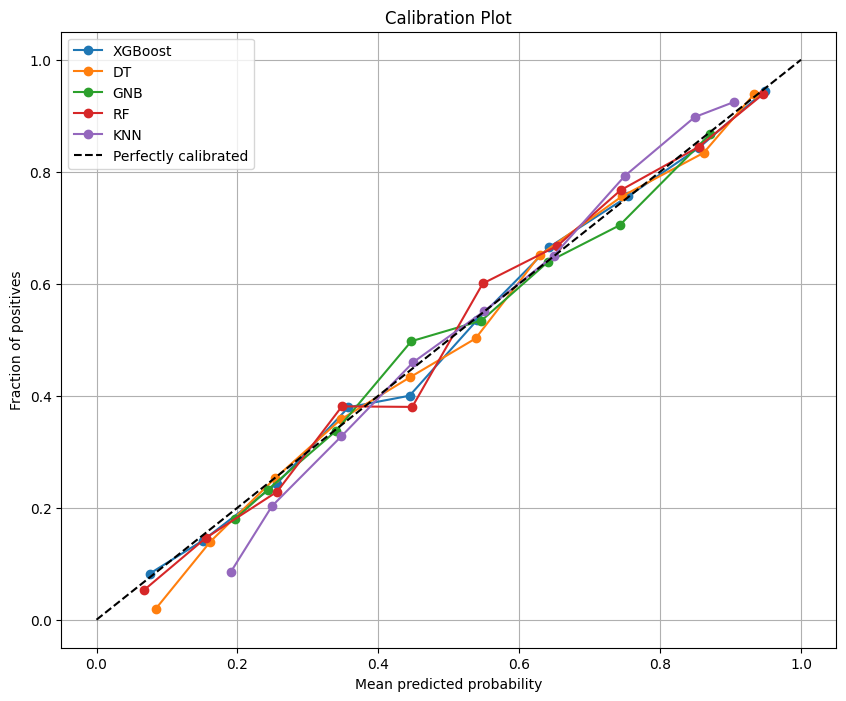

In [34]:
# Calibration plot
plt.figure(figsize=(10, 8))

for name, clf in text_based_classifiers.items():

    # Get calibrated probabilities
    prob_pos = clf.predict_proba(x_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    # Plot calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=name)

# Plot reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')

# Add labels and legend
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()